In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, os, glob
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

In [2]:
def run_preprocess(df_in):
    df_out = df_in.copy()

    if '날짜' in df_out.columns:
        df_out[['날짜']] = df_out[['날짜']].fillna(method='ffill')
        df_out['date_time'] = [pd.to_datetime(re.sub(r"[ㄱ-ㅣ가-힣]", "", df_out['날짜'].values[i]) + str(df_out['시간'].values[i])) for i in range(df_out.shape[0])]
        df_out = df_out.iloc[:, 2:]
    df_out = df_out.replace('s', 0)
    df_out.iloc[:,:11] = df_out.iloc[:,:11].astype(np.float64)

    df_out["datetime-year"] = df_out["date_time"].dt.year
    df_out["datetime-month"] = df_out["date_time"].dt.month
    df_out["datetime-day"] = df_out["date_time"].dt.day
    df_out["datetime-hour"] = df_out["date_time"].dt.hour
    df_out["datetime-minute"] = df_out["date_time"].dt.minute
    df_out["datetime-dayofweek"] = df_out["date_time"].dt.dayofweek

    return df_out

# 시간 데이터에 대한 Cyclic 인코딩 함수
def cyclic_encoding(data, max_value):
    # 사인과 코사인 값을 계산
    sin_values = np.sin(2 * np.pi * data / max_value)
    cos_values = np.cos(2 * np.pi * data / max_value)
    return sin_values, cos_values

def run_cyclic_encoding(df_in):
    df_out = df_in.copy()
    # year 변수를 Cyclical Encoding으로 변환하여 대체하기
    max_year = df_out['datetime-year'].max()
    df_out['year_sin'], df_out['year_cos']= cyclic_encoding(df_out['datetime-year'], max_year)
    df_out.drop('datetime-year', axis=1, inplace=True)

    # month 변수를 Cyclical Encoding으로 변환하여 대체하기
    max_month = 12
    df_out['month_sin'], df_out['month_cos']= cyclic_encoding(df_out['datetime-month'], max_month)
    df_out.drop('datetime-month', axis=1, inplace=True)

    # day 변수를 Cyclical Encoding으로 변환하여 대체하기
    max_day = 31
    df_out['day_sin'], df_out['day_cos']= cyclic_encoding(df_out['datetime-day'], max_day)
    df_out.drop('datetime-day', axis=1, inplace=True)

    # hour 변수를 Cyclical Encoding으로 변환하여 대체하기
    max_hour = 22
    df_out['hour_sin'], df_out['hour_cos']= cyclic_encoding(df_out['datetime-hour'], max_hour)
    df_out.drop('datetime-hour', axis=1, inplace=True)

    max_min = 30
    minute_sin, minute_cos = cyclic_encoding(df_out['datetime-minute'], max_min)
    df_out['minute_sin'], df_out['minute_cos']= cyclic_encoding(df_out['datetime-minute'], max_hour)
    df_out.drop('datetime-minute', axis=1, inplace=True)

    return df_out

In [3]:

def get_indices_entire_sequence(
        data: pd.DataFrame,
        window_size: int,
        step_size: int
) -> list:
    stop_position = len(data) - 1  # 1- because of 0 indexing

    # Start the first sub-sequence at index position 0
    subseq_first_idx = 0

    subseq_last_idx = window_size

    indices = []

    while subseq_last_idx <= stop_position:
        indices.append((subseq_first_idx, subseq_last_idx))

        subseq_first_idx += step_size

        subseq_last_idx += step_size

    return indices


def get_xgboost_x_y(
        indices: list,
        data: np.array,
        target_sequence_length,
        input_seq_len: int
):
    print("Preparing data..")

    # Loop over list of training indices
    for i, idx in enumerate(indices):
        # Slice data into instance of length input length + target length
        x = data[idx[0]:idx[1], :]

        assert len(x) == input_seq_len

        y = data[idx[1] + target_sequence_length - 1, -1]

        # Create all_y and all_x objects in first loop iteration
        if i == 0:
            all_y = y.reshape(1, -1)
            all_x = x.reshape(1, -1)
        else:
            all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0)
            all_x = np.concatenate((all_x, x.reshape(1, -1)), axis=0)

    print("Finished preparing data!")
    return all_x, all_y


In [4]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


def xgb(params=None):
        
    xgb_model = XGBRegressor(**params) if params is not None else XGBRegressor() # parameter 수정 된 파라미터가 있을 시 해당 parameter 적용, 아니면 그냥 기본 모델 적용

    return xgb_model


def run_xgb(data_dict):
    '''
        Xgboost regressor Model 을 run 하기 위한 함수,
        Input 은 data_dict 로 train, test, std, mean, EPOCHS 등 의 정보를 담고 있다.

        Output 은 pandas series 형식 으로 xgb mse와, numpy array 형식으로 학습된 Model의 test data 예측 값이 출력됨.

        GridCV로 파라미터 최적화 과정이 코드 내 구성 되어 있지만, 시간이 너무 오래걸려서 일단 막아 두었음.
    '''
    result_df = pd.DataFrame()

    train_x, train_y, test_x, test_y = data_dict['train_x'],data_dict['train_y'], data_dict['test_x'],data_dict['test_y']
    # xgb_params = {
    #       'max_depth': [2, 4, 6],
    #       'n_estimators': [100, 500, 1000],
    #       'colsample_bytree': [0.2, 0.6, 0.8],
    #       'min_child_weight': [3, 5, 7],
    #       'gamma': [0.3, 0.5, 0.7],
    #       'subsample': [0.4, 0.6, 0.8]
    #       }
    # gridcv = GridSearchCV(xgb(), param_grid=xgb_params, cv=5)
    #
    # gridcv.fit(train_x, train_y)
    # print(gridcv.best_params_)

    set_params = {'colsample_bytree': 0.2,
                  'gamma': 0.3,
                  'max_depth': 2,
                  'min_child_weight': 3,
                  'n_estimators': 100,
                  'subsample': 0.4}
    model_xgb = xgb(set_params).fit(train_x, train_y)

    # model_xgb = MultiOutputRegressor(xgb(gridcv.best_params_)).fit(train_x, train_y)

    # test data 예측 및 mse loss 계산
    normed_test_predictions = model_xgb.predict(test_x)
    zeros = np.where(normed_test_predictions<0)[0]
    normed_test_predictions[zeros] = 0
    normed_test_predictions = normed_test_predictions.astype(np.int32)

    print('xgb mse : ', np.mean(np.square(normed_test_predictions-test_y.reshape(-1))))
    print('xgb r2 : ', r2_score(test_y.reshape(-1), normed_test_predictions))
    #결과 data frame에 해당 loss 값 할당
    result_df['xgboost_mse'] = pd.Series(np.mean(np.square(normed_test_predictions-test_y.reshape(-1,1))))
    result_df['xgboost_r2'] = pd.Series(r2_score(test_y.reshape(-1,1), normed_test_predictions))

    return model_xgb, normed_test_predictions.reshape(-1)



def run_forecast(df_in, train_ratio=0.8, seq_length=3, label='남은자리수'):
    df_out = df_in.copy()

    train_df = df_out.iloc[:int(df_out.shape[0]*train_ratio), :]
    test_df = df_out.iloc[int(df_out.shape[0]*train_ratio):, :]

    train_date, test_date = train_df['date_time'], test_df['date_time']

    train_df.drop('date_time', axis=1, inplace=True)
    test_df.drop('date_time', axis=1, inplace=True)

    train_x, train_y = train_df.drop(label, axis=1), train_df[[label]].reset_index(drop=True)
    test_x, test_y = test_df.drop(label, axis=1), test_df[[label]].reset_index(drop=True)
    cols = train_x.columns

    scaler = MinMaxScaler()

    scaler.fit(train_x)

    train_vals = scaler.transform(train_x)
    test_vals = scaler.transform(test_x)

    train_x = pd.concat([pd.DataFrame(train_vals, columns=cols), train_y],axis=1)
    test_x = pd.concat([pd.DataFrame(test_vals, columns=cols),test_y], axis=1)
    
    normed_train_data = train_x.values
    normed_test_data = test_x.values

    indices_tr = get_indices_entire_sequence(data=train_x, window_size=seq_length, step_size=1) # data에 따른 train index 생성
    indices_te = get_indices_entire_sequence(data=test_x, window_size=seq_length, step_size=1) # data에 따른 test index 생성

    xg_train_x, xg_train_y= get_xgboost_x_y(indices=indices_tr, data=normed_train_data, target_sequence_length=1, input_seq_len=seq_length) # index에 따른 train data 생성
    xg_test_x, xg_test_y= get_xgboost_x_y(indices=indices_te, data=normed_test_data, target_sequence_length=1, input_seq_len=seq_length) # index에 따른 test data 생성

    train_test_dict = {}
    
    train_test_dict['train_x'],train_test_dict['train_y'], train_test_dict['test_x'],train_test_dict['test_y'] = xg_train_x, xg_train_y, xg_test_x, xg_test_y
    train_test_dict['test_data'] = test_x
    train_test_dict['train_date'], train_test_dict['test_date'] = train_date, test_date 
    train_test_dict['scaler'] = scaler

    model, pred_y = run_xgb(data_dict=train_test_dict)

    plt.figure(figsize=(20,5))
    plt.plot(test_date[3:], pred_y,label='pred')
    plt.plot(test_date[3:], xg_test_y, label='real')

    plt.legend(loc='best')

    return model, train_test_dict

건대더이퀼리브리엄커피


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
xgb mse :  11.558704453441296
xgb r2 :  0.92859414117756


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

건대스타벅스


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
xgb mse :  5.825910931174089
xgb r2 :  0.9294835291923038


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

건대엔젤이너스


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
xgb mse :  28.39068825910931
xgb r2 :  0.9159886897484084


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

구의역이디야


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
xgb mse :  1.2064777327935223
xgb r2 :  0.9208183658447311


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

구의역탐앤탐스블랙그레이트점


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
xgb mse :  17.87854251012146
xgb r2 :  0.9633196603267216


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

구의역투썸플레이스


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
xgb mse :  2.534412955465587
xgb r2 :  0.9774598997093674


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

스타벅스건대후문점


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
xgb mse :  2.479757085020243
xgb r2 :  0.9181073494035904


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

카페온더플랜


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
xgb mse :  21.52834008097166
xgb r2 :  0.9218499863177343


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

커피랑도서관어린이대공원


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
xgb mse :  2.7348178137651824
xgb r2 :  0.9649943751319148


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

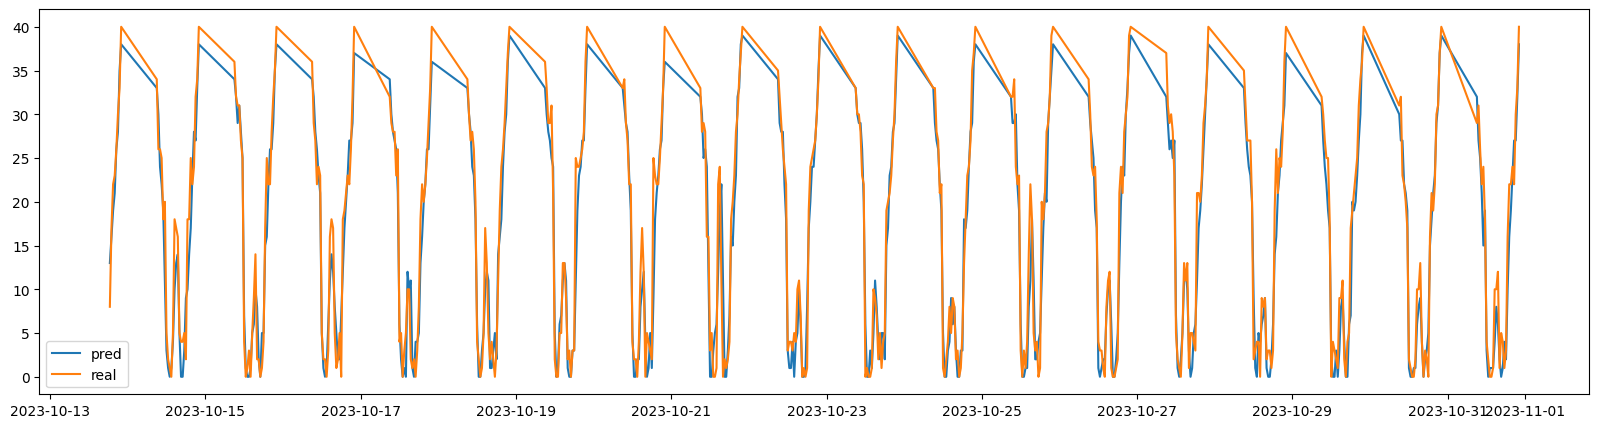

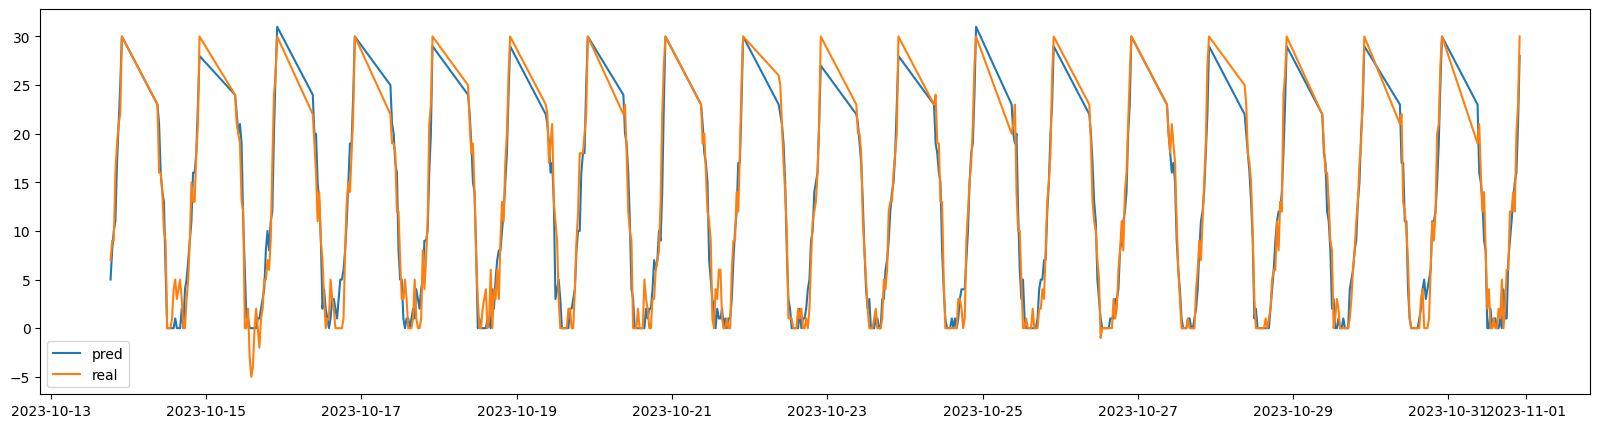

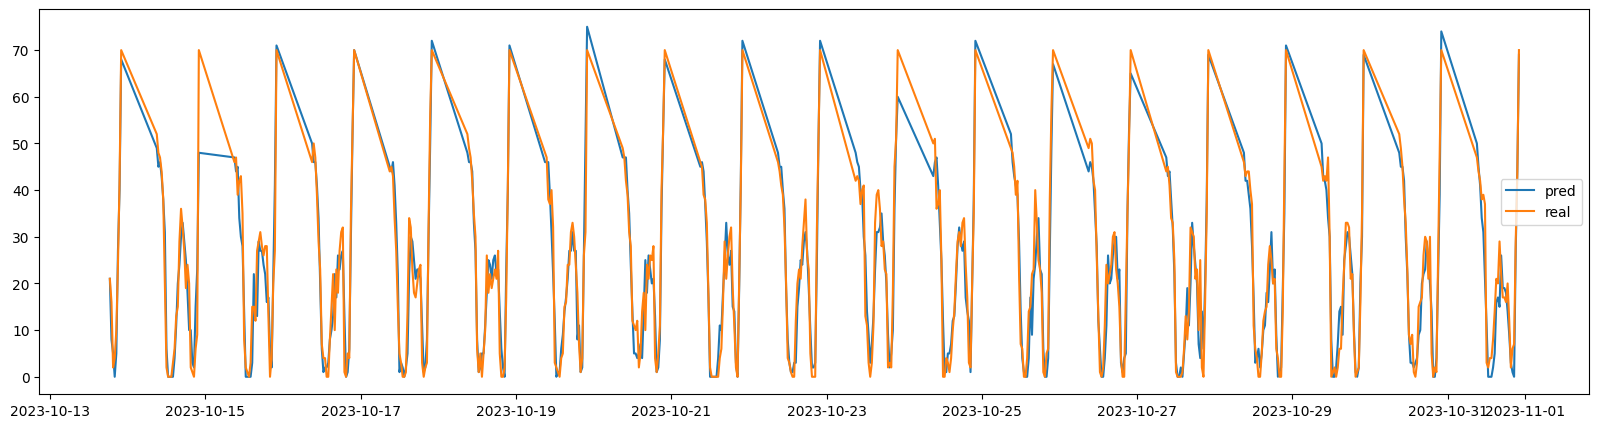

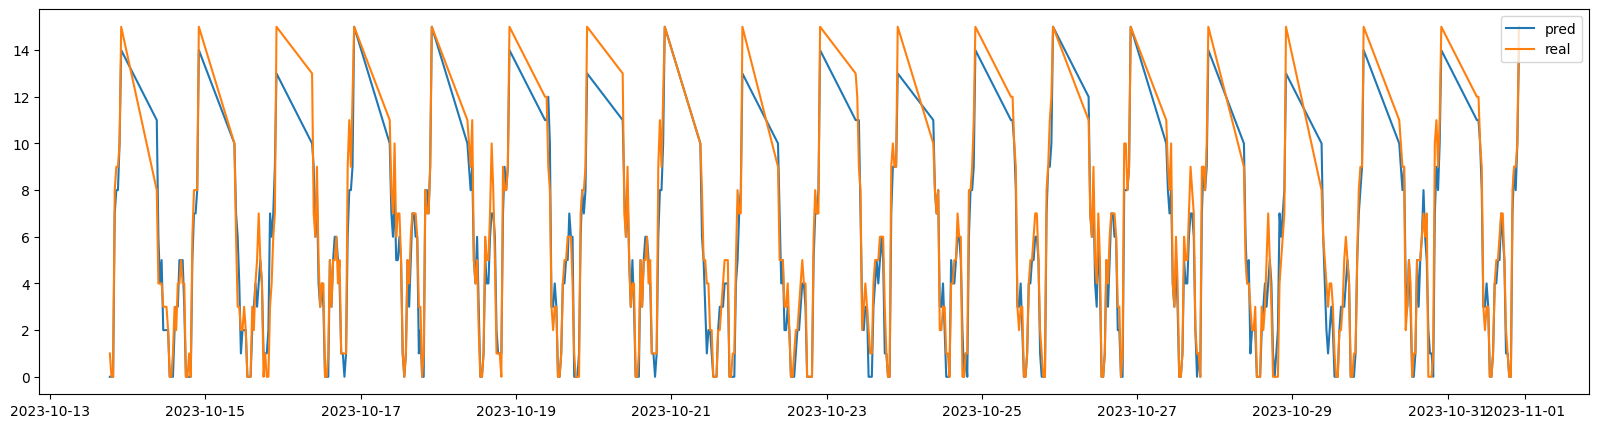

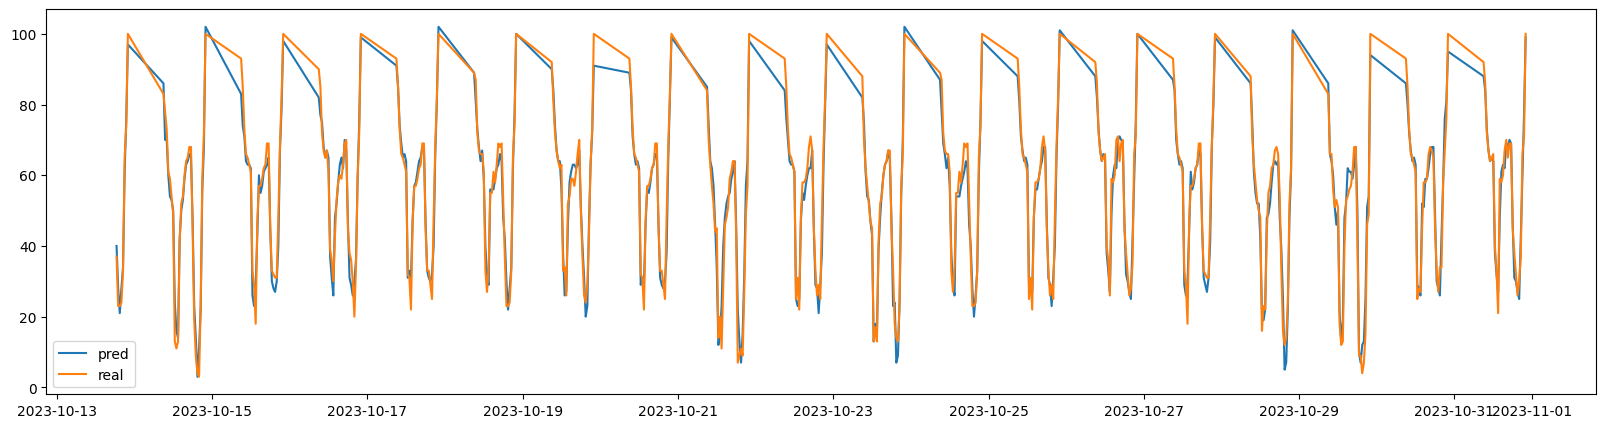

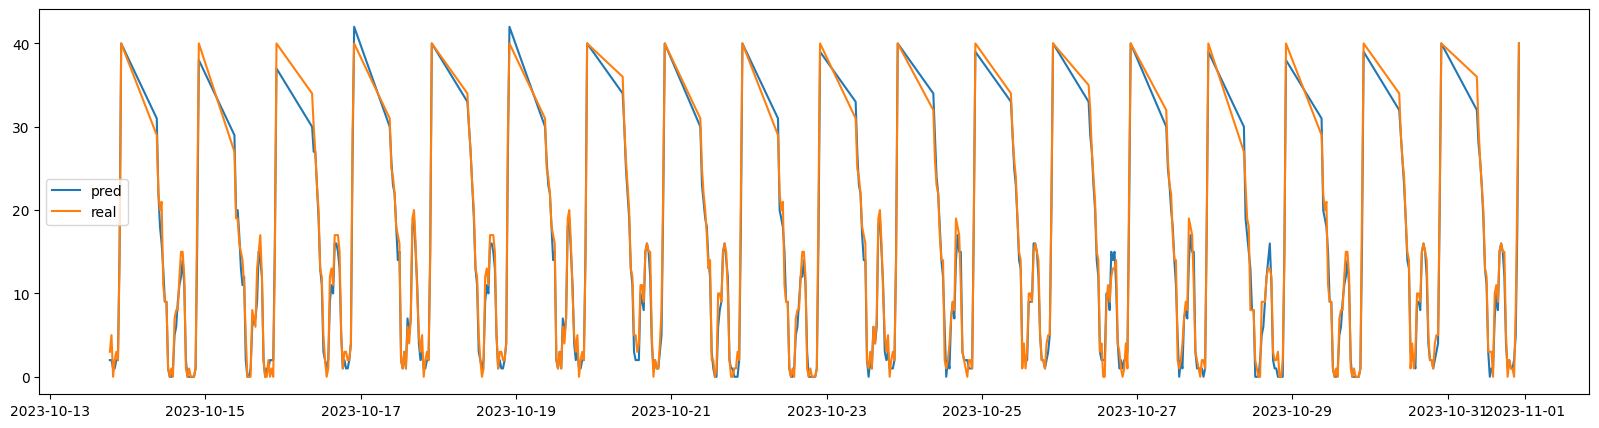

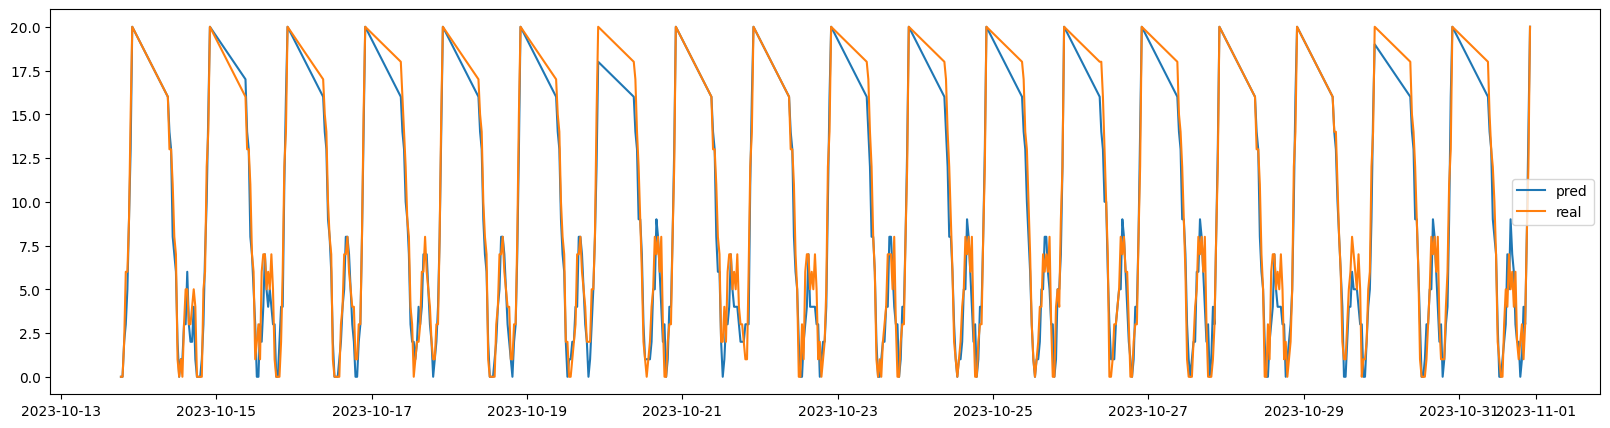

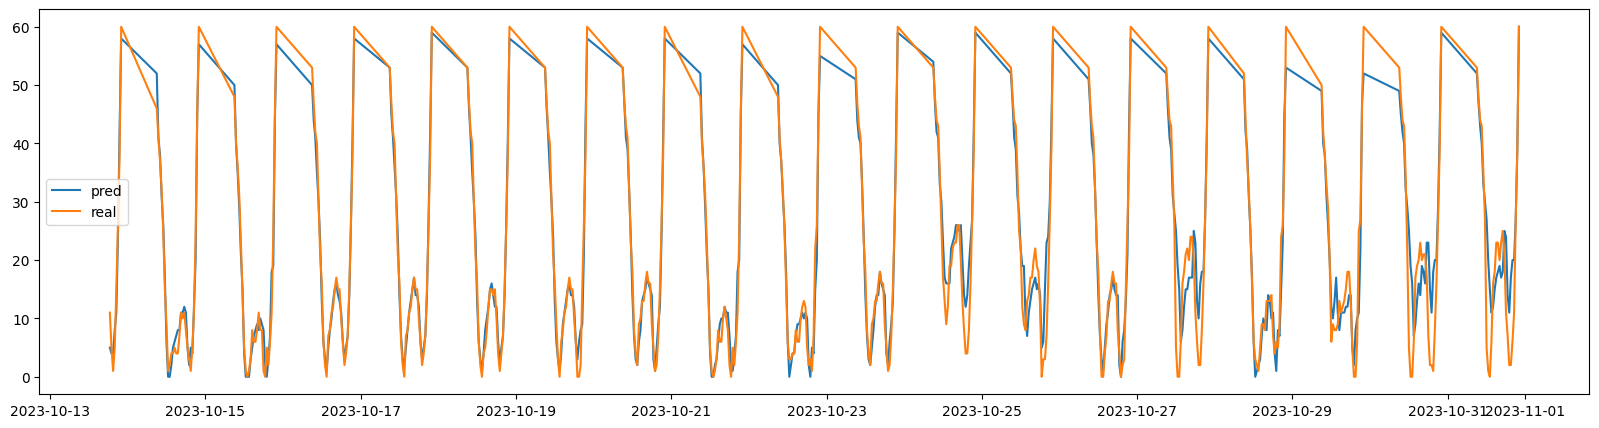

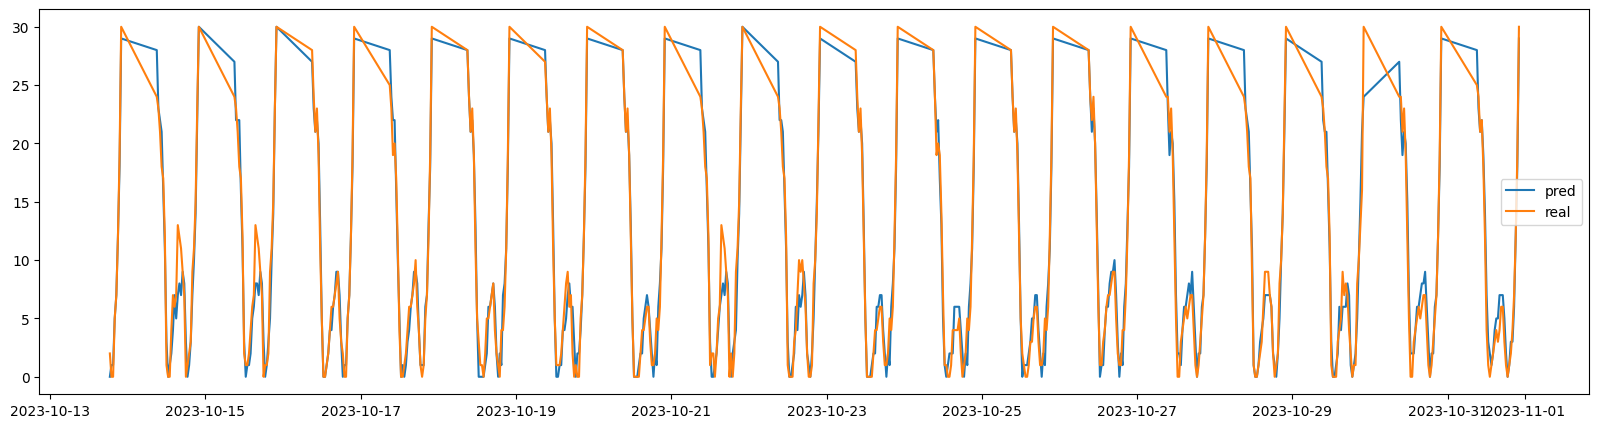

In [5]:
cafes = glob.glob(os.path.join('*.xlsx'))

seq_length = 3
label='남은자리수'

# 11월 한 달간의 날짜 범위 설정
start_date = "2023-11-01 09:00:00"
end_date = "2023-11-30 22:00:00"

# 30분 간격으로 시간 데이터 생성
time_data = pd.date_range(start=start_date, end=end_date, freq='30min')

# 오전 9시부터 오후 10시 사이의 시간만 필터링
filtered_time_data = time_data[(time_data.hour >= 9) & (time_data.hour <= 22)]
filtered_time_data = filtered_time_data[~((filtered_time_data.hour==22) & (filtered_time_data.minute==30))]


for c in cafes:
    cafe_name = c.strip('.xlsx')
    print(cafe_name)
    test = pd.read_excel(c)

    val_df = run_preprocess(df_in=test)
    pp_df = run_cyclic_encoding(df_in=val_df)

    model, data_info = run_forecast(df_in=pp_df, train_ratio=0.8, seq_length=seq_length)

    test_df = val_df.copy()

    test_x = data_info['test_data']
    tabel_num = test_df[['사람이 있는 테이블갯수', '남은자리수']].iloc[0, :].sum()
    test_pred = []
    wait_dict = {}
    waiting_start, waiting_end = None, None
    for idx, test_time in enumerate(filtered_time_data):
        cust_vals = np.round(test_df.iloc[test_df[test_df['date_time']==(test_time - timedelta(days=seq_length))].index[0]::27, :11].mean(axis=0).values, 0)
        table_in_use = np.sum(cust_vals).astype(np.int32)
        remain_seats = tabel_num-table_in_use
        new_df = pd.DataFrame(np.hstack([cust_vals, table_in_use, remain_seats, test_time]).reshape(1,-1), columns=test_df.columns[:14])
        new_ppdf = run_preprocess(new_df)
        test_df = pd.concat([test_df, new_ppdf], axis=0).reset_index(drop=True)
        
        # display(test_df.tail())
        if idx==0:
            test_vals = test_x[-seq_length:].values.reshape(1,-1)
        else:
            target_df = run_cyclic_encoding(test_df[-seq_length:]).drop('date_time',axis=1)
            target_x, target_y = target_df.drop(label, axis=1), target_df[[label]].reset_index(drop=True)
            cols = target_x.columns
            target_x_scaled = data_info['scaler'].transform(target_x)
            test_vals = pd.concat([pd.DataFrame(target_x_scaled, columns=cols),target_y], axis=1).values.reshape(1,-1)

        prd_y = model.predict(test_vals)
        zeros = np.where(prd_y<0)[0]
        prd_y[zeros] = 0
        prd_y = prd_y.astype(np.int32)
        if (prd_y == 0) and (waiting_start is None):
            waiting_start = test_time
            # print(f'{waiting_start} 자리 개수가 0 입니다.')
        elif (prd_y != 0) and (waiting_start is not None):
            waiting_end = test_time
            waiting_time = waiting_end - waiting_start
            # print('예상 대기 시간:',waiting_time.total_seconds() / 60, 'min')
            wait_dict[waiting_start] = waiting_time.total_seconds() / 60
            waiting_start = None
        if test_time not in wait_dict.keys():
            wait_dict[test_time] = 0
        # print()
        test_pred.append(prd_y[0])

    save_df = test_df[test_df['date_time'].isin(filtered_time_data)]
    save_df['pred_tables'] = test_pred
    save_df['wait_time'] = save_df['date_time']
    save_df['wait_time'] = save_df['wait_time'].replace(wait_dict)

    edit_info = [(i, int(save_df.loc[i, 'wait_time']/30)-1) for i in save_df[save_df['wait_time']!=0].index]
    
    for idx, iter_n in edit_info:
        if iter_n==0:
            continue
        else:
            initial = save_df.loc[idx, 'wait_time']
            for j in range(iter_n):
                initial = initial-30
                save_df.loc[idx+j+1, 'wait_time'] = initial
    
    save_df.to_csv(f'{cafe_name}_{max(filtered_time_data.month)}월_대기시간예측.csv',index=False,encoding="utf-8-sig")

In [6]:
coordinate = { 
                '건대더이퀼리브리엄커피' : [37.54032309999999, 127.0678208],
                '건대스타벅스' : [37.5406354, 127.0707535],
                '건대엔젤이너스' : [37.5407625, 127.0793428],
                '구의역이디야' : [37.5444007, 127.092844],
                '구의역탐앤탐스블랙그레이트점' : [37.537153, 127.086152],
                '구의역투썸플레이스' : [37.537153, 127.086152],
                '스타벅스건대후문점' : [37.5460906, 127.0740003],
                '카페온더플랜' : [37.5451809, 127.0727712],
                '커피랑도서관어린이대공원' : [37.5466325, 127.0735754]
             }

In [25]:
current_coord = [37.54185474636368 , 127.07165259211244]

dist =[(k, np.sqrt((v[0]-current_coord[0])**2 + (v[1]-current_coord[1])**2)) for k, v in coordinate.items()]
dist.sort(key=lambda x : (x[1]),reverse=False )
recommend = [dist[i][0] for i in range(3)]

In [50]:
hope_time = pd.to_datetime('2023-11-11 14:00')

final_result = {}

for r in recommend:
    df = pd.read_csv(glob.glob(os.path.join(f'{r}*.csv'))[0])
    df['date_time'] = pd.to_datetime(df['date_time'])
    w_time = '예상 대기시간 '+str(int(df[df['date_time']==hope_time]['wait_time'].values[0])) + ' min'
    final_result[r] = w_time


In [51]:
final_result

{'건대스타벅스': '대기시간 90 min', '카페온더플랜': '대기시간 0 min', '건대더이퀼리브리엄커피': '대기시간 0 min'}